AF


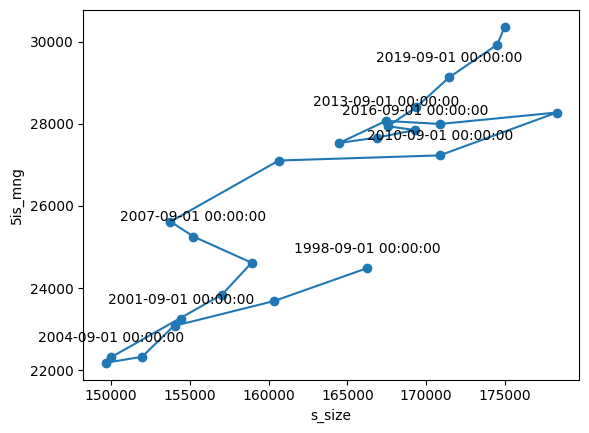

AG


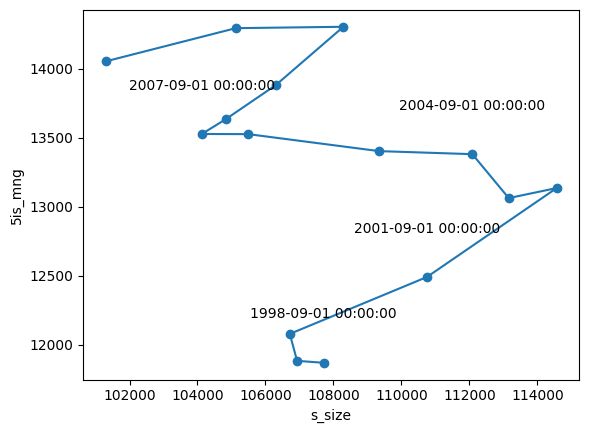

AR


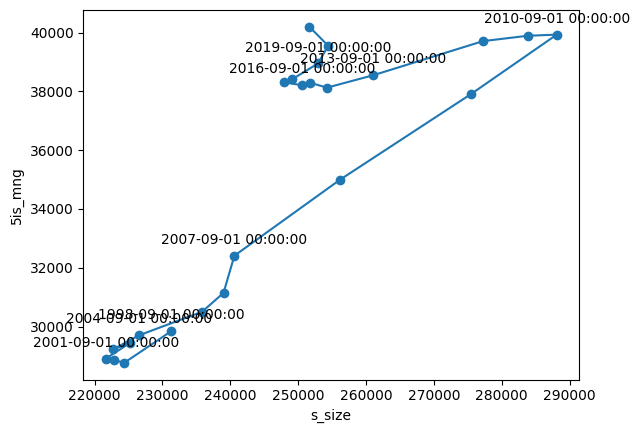

DD


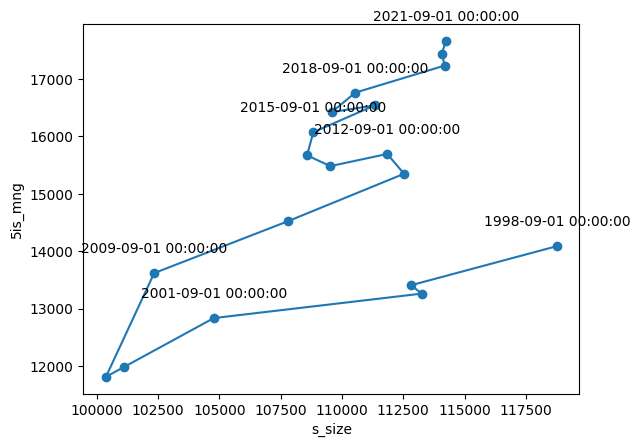

DJ


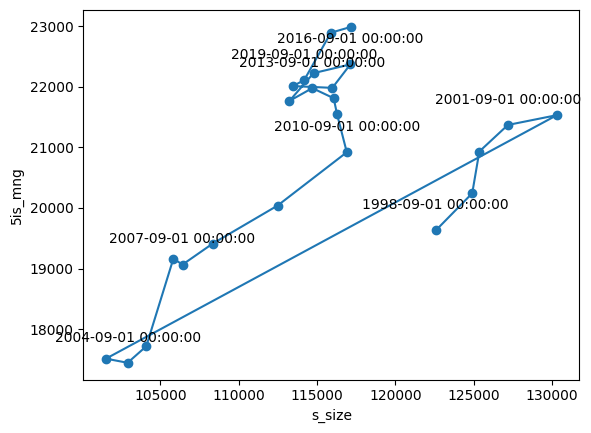

HS


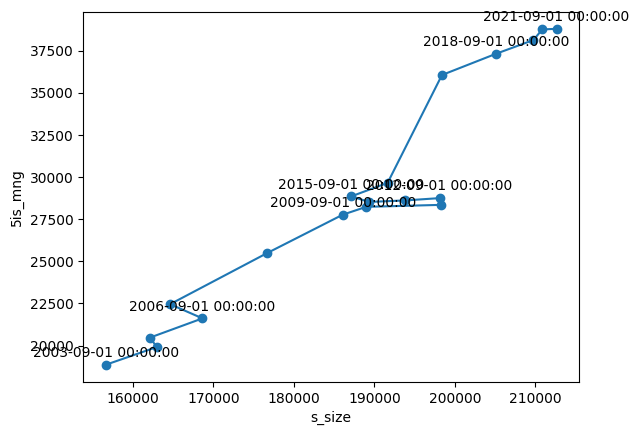

NV


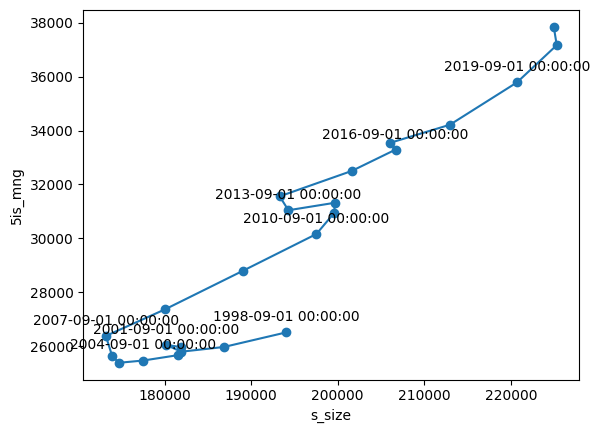

TD


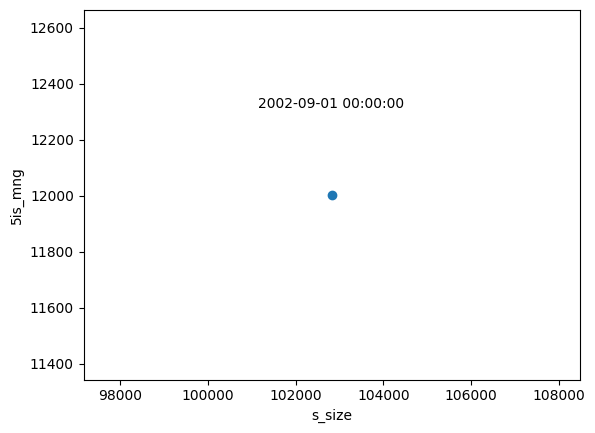

TR


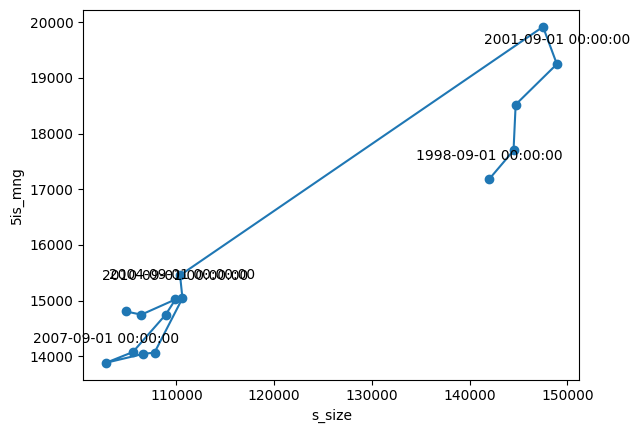

VA


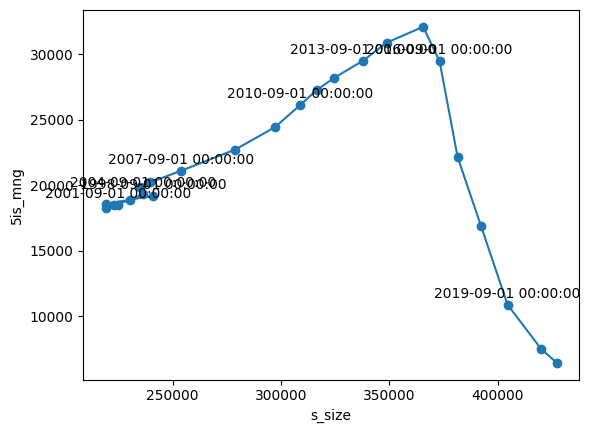

In [4]:
df1 = pd.read_pickle("checking_in.pkl")
df1 = df1[df1.s_size > 100000]
agy = df1['3AGY'].unique()
for a in agy:
    df = df1[ (df1['3AGY'] == a)].loc[:, ['3AGY', 'DATECODE', 's_size', '5is_mng']]
    df.set_index('DATECODE', inplace=True)
# plot the connected scatterplot # groupby agency plot
    print(a)
    plt.plot(df.s_size, df['5is_mng'], '-', marker='o') #by = 
    # add annotations in every 3 data points with a loop
    for line in range(0, df.shape[0], 3):
        plt.annotate(
            df.index[line], 
            (df.s_size.iloc[line], df['5is_mng'].iloc[line]+300 ) ,
            va='bottom',
            ha='center'
        )
    # x axis label
    plt.xlabel('s_size')
    plt.ylabel('5is_mng')
    plt.show()

## WORKFLOW; ask Angie if you need pipeline work on clustering, filtering out, plotting.

In [5]:
import pandas as pd
import string
import xarray as xr
import pandas as pd
import numpy as np
from workflow import *
import matplotlib.pyplot  as plt
workflow = ['forming_size_share','checking_in','forming_cluster', 'plotting']#['checking_out','forming_size_share','checking_in','forming_cluster', 'plotting']

for w in workflow:
    iter_agency(ITER = w, disagg='by_ts')
    #iter_agency(ITER = w, disagg='by_t')
    #iter_agency(ITER = w, disagg='by_ts')

def iter_forming(ITER_IN:str, ITER:str, disagg: str, time_resol:str= 'DATECODE', space_resol:str = '3AGY'): # ratio total 
    '''
    ITER_IN: checking_out, checking_out
    ITER: forming_share_size, forming_cluster. chained (ITER_IN, ITER) makes dict() input a better implementation, by (checking_out, forming_cluster) may be possible
    diagg: by_s, by_st, by_t
    time_resol: 'month', 'year' can be derived from 'DATECODE' #TODO
    '''
    df = pd.read_pickle(f'{ITER_IN}.pkl')
    if ITER == 'forming_size_share':
        # for clustering, it might help to have further specification
        # space_resol = '3AGY':
            # clustering happens on the same level of one agent
        # space_resol =  '4AGYSUB'
            # clustering happens on the one level up of one agent (agency)

        if disagg == 'by_s':
            ts_group = df.groupby(space_resol)

        elif disagg == 'by_t':
            ts_group = df.groupby(time_resol)

        elif disagg == 'by_ts':
            ts_group = df.groupby([space_resol, time_resol])

        s_size = ts_group['EMPLOYMENT'].sum()
        mng = ts_group['5is_mng'].sum()
        mng_frac = pd.concat([s_size, mng], axis =1, ignore_index=False) #indexing with space_resol
        mng_frac.rename(columns={"EMPLOYMENT":"s_size"}, inplace = True)
        mng_frac["reg_frac"]= mng_frac["5is_mng"]/mng_frac["s_size"]
        df['mng_size'] = df['s_size'] * df['reg_frac']
        mng_frac.reset_index(inplace=True)
        save_iter(mng_frac, ITER, disagg) #if merge takes too long
        
    elif ITER == 'forming_cluster':
        df = pd.read_pickle(f'{ITER_IN}.pkl')
        max_comp = 4
        cf = np.zeros(max_comp).tolist()
        def standardize(df:pd.Series) -> pd.Series:
            return (df-df.median())/(df.max() - df.min())
        def log_standardize(df:pd.Series) -> pd.Series:
            df = df.apply(np.log)
            return (df-df.median())/(df.max() - df.min())

        cluster_df = df.assign(std_size = log_standardize(df.s_size), std_ratio = standardize(df.reg_frac)).groupby(space_resol).mean()
        cluster_df.dropna(inplace = True) #3 dropped from log(ratio =0)
        for m in range(2, max_comp):
            cf[m] = GaussianMixture(n_components = m).fit(X = cluster_df[['std_size', 'std_ratio']])
            cluster_df.loc[:, f'c_{m}'] = cf[m].predict(X = cluster_df[['std_size', 'std_ratio']])
            scale_plot(df, disagg, time_resol, space_resol)
            plt.figure(figsize=(15,8))
            sns.scatterplot(cluster_df,  x='std_size', y='std_ratio', hue= f'c_{m}')
            plt.savefig(f"{get_plot_path('agency')}/c_{m}_cluster_{disagg}" + ".png")
        #clustered = df.merge(cluster_df, on = space_resol,)
        save_iter(cluster_df, ITER, disagg)

def iter_plotting(ITER_IN, ITER, disagg):
    # EB vs HF, Education large variation
    df = pd.read_pickle(f'{ITER_IN}.pkl')
    
    scale_plot(df, disagg)
    fig, axes = plt.subplots(1,5, figsize  = (40,15))
    # high_reg_frac = ['AB', 'NK', 'EQ']  # AMERICAN BATTLE MONUMENTS COMMISSION, NATIONAL COUNCIL ON DISABILITY, COUNCIL ON ENVIRONMENTAL QUALITY
    # low_reg_frac = ['ZL', 'VA', 'SB'] # MEDICARE PAYMENT ADVISORY COMMISSION, dep. OF VETERANS AFFAIRS, SMALL BUSINESS ADMINISTRATION'
    # # high freq = large std (assuming oscillation)
    # high_freq = ['VD', 'GX', 'BH', 'ZS'] # privacy-civil liberties oversight board, intl boudary commission:US-Canada,
    #                                     # commission for US heritage abraod presvation, US-canada econ+security review commission
    # low_freq = ['AF', 'TR', 'NU', 'FT'] # air force, dep. of treasury, dep. of treasury, privacy+civil liberties oversight board 
    # theor_responsive = ['NN', 'NF', 'JL', 'HB'] # nasa, nsf, judicial branch, committee for purchase from bind or severly disabled ppl

    # sns.lineplot(df[df['3AGY'].isin(high_reg_frac)], x = 'DATECODE', y = 'reg_frac', ax = axes[0], hue = '3AGY')
    # sns.lineplot(df[df['3AGY'].isin(low_reg_frac)], x = 'DATECODE', y = 'reg_frac', ax = axes[1], hue = '3AGY')
    # sns.lineplot(df[df['3AGY'].isin(high_freq)], x = 'DATECODE', y = 'reg_frac', ax = axes[2], hue = '3AGY')
    # sns.lineplot(df[df['3AGY'].isin(low_freq)], x = 'DATECODE', y = 'reg_frac', ax = axes[3], hue = '3AGY')
    # sns.lineplot(df[df['3AGY'].isin(theor_responsive)], x = 'DATECODE', y = 'reg_frac', ax = axes[4], hue = '3AGY')

    save_iter(df, ITER, disagg)


def branching(df, time_resol:str= 'DATECODE', space_resol:str = '3AGY',branch='senate', from_top=True):
    """
    features: features from below to be tracked other than agnecy hierarchy five level ('AGYTYP', 'AGY', 'AGYSUB') e.g. SALARY
    # original data FACDATA.txt col" ['AGYSUB', 'LOC', 'AGELVL', 'EDLVL', 'GSEGRD', 'LOSLVL', 'OCC', 'PATCO',
    #          'PP', 'PPGRD', 'SALLVL', 'STEMOCC', 'SUPERVIS', 'TOA', 'WORKSCH',
    #          'WORKSTAT', 'DATECODE', 'EMPLOYMENT', 'SALARY', 'LOS', 'AGYTYP',
    #          'AGYTYPT', 'AGY', 'AGYT', 'AGYSUBT'] and by default it is organized into 1-4-130-530-1060 hierarchy
    
    layers: degree of fineness for organization hierarchy after merge(fact,agy)-> groupby, it hierarchize according to `layers`.
    layer 5:                     SUPERVIS
    layer 4:                AGYSUB
    layer 3:              AGY
    layer 2:        AGYTYP
    layer 1: AGY_arch
    """
    if branch == 'mng':
        df['is_mng'] = df["SUPERVIS"].isin(['2', '6', '7']) 

    elif branch == 'senate': # us federal agency, by agency
        #df = df.reset_index()
        size = len(set(df[space_resol]))
        if 'EMPLOYMENT' in df.columns:
            sorted_state = df.groupby(space_resol)['EMPLOYMENT'].count().sort_values()
        else:
            sorted_state = df.groupby(space_resol)['s_size'].count().sort_values()
        # largest
        # VA: dep. verterans affairs (defense) 300k - why this many? + some innovative dep??
        # AR: dep. of army (defense) 250k
        # NV: dep. of navy (defense) 200k
        # AF: dep. of air force (defense) 150k
        # HS: dep. homeland security (defense) 100k
        # DJ: dep. justice 100k
        # TR: dep. treasury 100k
        # DD: dep. of defense 100k
        # AG: dep. of agriculture 100k (innovative)
        # HE: dep. of health and human service 75k

        # high reg frac
        # AB: AMERICAN BATTLE MONUMENTS COMMISSION (.8)
        # NK: NATIONAL COUNCIL ON DISABILITY (.6)
        # EQ: COUNCIL ON ENVIRONMENTAL QUALITY/OFFICE OF ENVIRONMENTAL QUALITY'
        
        # low reg frac
        # ZL:  MEDICARE PAYMENT ADVISORY COMMISSION (.02)
        # VA: DEPARTMENT OF VETERANS AFFAIRS
        # SB-SMALL BUSINESS ADMINISTRATION'
        
        # large oscilation (top10, >10 year) - responsive
        # VD: PRIVACY AND CIVIL LIBERTIES OVERSIGHT BOARD
        # GX: INTERNATIONAL BOUNDARY COMMISSION: UNITED STATES AND CANADA (regulating regulators of conflict)
        # BH: COMMISSION FOR THE PRESERVATION OF AMERICA'S HERITAGE ABROAD  0.374149

        # small oscialation (< .01, > 10 year)
        # NU: NUCLEAR REGULATORY COMMISSION 0.005
        # FT: FEDERAL TRADE COMMISSION      0.006
        # TR: DEPARTMENT OF THE TREASURY .006
        # AF: AIR FORCE .009

        # ZS-UNITED STATES-CHINA ECONOMIC AND SECURITY REVIEW COMMISSION', (.5)
        # MI: MILLENNIUM CHALLENGE CORPORATION (.6)
        # NS-NATIONAL SECURITY COUNCIL (.6)
        # 'NF-NATIONAL SCIENCE FOUNDATION',
        ## notable
        # DB: PUBLIC INTEREST DECLASSIFICATION BOARD 0.439841 (small size, zero mng)
        # DG: NORTHERN BORDER REGIONAL COMMISSION (~5 but survivor! 10~21)
        # YF :??  0.478675 (two year: 10/11-13/56)

        
        ##########################################
        # df[(df.reg_frac > np.percentile(df.reg_frac, 95)) & (df.s_size > 30)]
        # df[df['3AGY'].isin(df.groupby('3AGY').reg_frac.std().dropna().sort_values()[-10:].index) & (df.s_size>10)]
        ##########################################
        if from_top:
            for tq in [.02, .05, .1]:
                s_state = sorted_state[int(-size*tq):]
                df = df.iloc[(np.where(~df[space_resol].isin(s_state.index)))]  
                #df = df.assign(is_stop = lambda x: x[space_resol].isin(s_state)) #doesn't filter out
                df.rename(columns = {'is_stop': f'is_stop{tq}'}, inplace=True)
        else:
            for bq in [.1]:
                s_state = sorted_state[:int(size*bq)]
                df = df.iloc[(np.where(~df[space_resol].isin(s_state.index)))] # cut-off 200, 'DO', 'GN', 'YG', 'DA', 'EV', 'IP', 'ZQ', 'ZN', 'YA', 'GU', 'WK', 'GZ','ZK', 'KY', 'AC', 
                #'YE' (two years) COMMISSION ON THE PREVENTION OF WEAPONS OF MASS DESTRUCTION PROLIFERATION AND TERRORISM
                df.rename(columns = {'is_sbot': f'is_sbot{bq}'}, inplace=True)
            #similar effect with df  = df[~(df.s_size < 10)] EXCEPT no s_size yet so need to extract index by first groupby 

    elif branch == 'representative': # us federal agency as a whole, proportional
        size = df.shape[0]
        sorted_state_cumsum = df.groupby(space_resol)['s_size'].count().sort_values().cumsum()
        if from_top:
            for tq in [.02, .05, .1]:
                r_state = sorted_state_cumsum > size* (1-tq)
                df[f'is_rtop{tq}'] = df[(np.where(~df[space_resol].isin(s_state.index)))] # doesn't work #TODO
                df = df.assign(is_rtop = lambda x: x[space_resol].isin(r_state))
                df.rename(columns = {'is_rtop': f'is_rtop{tq}'}, inplace=True)    
        else:
            for bq in [.1]:
                r_state = sorted_state_cumsum < size* bq
                df = df.assign(is_rbot = lambda x: x[space_resol].isin(r_state))
                df.rename(columns = {'is_rbot': f'is_rbot{bq}'}, inplace=True)
    return df

    space_resol_angle = dict(
        top1=['VA', 'AR'],
        top5=['VA', 'AR', 'NV','AF','HS'],
        high_reg_frac = ['AB', 'NK', 'EQ'],
        low_reg_frac = ['ZL', 'VA', 'SB'],
        high_freq = ['VD', 'GX', 'BH', 'ZS'],
        low_freq = ['AF', 'TR', 'NU', 'FT'], 
        theor_responsive = ['NN', 'NF', 'JL', 'HB']
    )
    # top10=['VA', 'AR', 'NV','AF','HS','DJ','TR','DD','AG','HE'],
    # defense=['AR','NV', 'AF','HS', 'DD'],
    # reg = ['AB', 'EQ', 'MI', 'NK', 'NS', 'RO', 'YD', 'ZS']
    # high_reg_frac = ['AB', 'NK', 'EQ']  # AMERICAN BATTLE MONUMENTS COMMISSION, NATIONAL COUNCIL ON DISABILITY, COUNCIL ON ENVIRONMENTAL QUALITY
    # low_reg_frac = ['ZL', 'VA', 'SB'] # MEDICARE PAYMENT ADVISORY COMMISSION, dep. OF VETERANS AFFAIRS, SMALL BUSINESS ADMINISTRATION'
    # # high freq = large std (assuming oscillation)
    # high_freq = ['VD', 'GX', 'BH', 'ZS'] # privacy-civil liberties oversight board, intl boudary commission:US-Canada,
    #                                     # commission for US heritage abraod presvation, US-canada econ+security review commission
    # low_freq = ['AF', 'TR', 'NU', 'FT'] # air force, dep. of treasury, dep. of treasury,
    # theor_responsive = ['NN', 'NF', 'JL', 'HB'] # nasa, nsf, judicial branch, committee for purchase from bind or severly disabled ppl
    df['DATECODE'] = df['DATECODE'].astype('int')
    plot_path = get_plot_path('agency')
    figsize = (20, 20)
    if disagg == "by_t": # TODO meaning of scaling analysis with marginalize over agency, one agency's time series is tricky for scaling analysis
        fig, axes = plt.subplots(1,2, figsize = figsize)
        # need groupby(space_resol), but seaborn provides "Passing the entire dataset in long-form mode will aggregate over repeated values (each year) to show the mean and 95% confidence interval:"
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)
        sns.lineplot(df, x='DATECODE', y='reg_frac', ax = axes[0]) # disagg by time = groupby space!
        sns.lineplot(df, x='DATECODE', y='s_size', ax = axes[1]) 

    elif disagg == "by_s": # space disaggregation
        _, axes = plt.subplots(1, len(space_resol_angle), figsize=figsize)
        plt.setp(axes, xlim = (10**5,5*10**6), ylim = (0,100))
        for i, agg in enumerate(space_resol_angle.values()): 
            axes[i].set(xscale="log", yscale="log")
            sns.scatterplot(df[df[space_resol].isin(agg)],  x='s_size', y='reg_frac',hue=space_resol, ax = axes[i])
        
    elif disagg == "by_ts": # timeXspace disaggregation
        _, axes = plt.subplots(1, len(space_resol_angle), figsize=figsize)
        
        for i, agg in enumerate(space_resol_angle.values()):
            axes[i].set(xscale="log", yscale="log")
            sns.scatterplot(df[['s_size', 'reg_frac',time_resol]],  x='s_size', y='reg_frac',hue=time_resol, ax = axes[i])
            df['mng_size'] = df['s_size'] * df['reg_frac'] 

            
            sns.scatterplot(df, x='s_size', y='mng_size',hue='DATECODE', ax =ax)
    plt.show()
    plt.savefig(f"{get_plot_path('agency')}/loglog_share_size_{disagg}" + ".png")
    plt.clf()

def scale_plot(df, disagg, time_resol = 'DATECODE', space_resol = '3AGY'):
    space_resol_angle = dict(
        # top1=['VA', 'AR'],
        # high_freq = ['VD'],
        # low_freq = ['AF'],
        top1=['VA', 'AR'],
        #top5=['VA', 'AR', 'NV','AF','HS'],
        #high_reg_frac = ['AB', 'NK', 'EQ'],
        #low_reg_frac = ['ZL', 'VA', 'SB'],
        high_freq = ['VD', 'GX', 'BH', 'ZS'],
        low_freq = ['AF', 'TR', 'NU', 'FT'], 
        theor_responsive = ['NN', 'NF', 'JL', 'HB']
    )
    # top10=['VA', 'AR', 'NV','AF','HS','DJ','TR','DD','AG','HE'],
    # defense=['AR','NV', 'AF','HS', 'DD'],
    # reg = ['AB', 'EQ', 'MI', 'NK', 'NS', 'RO', 'YD', 'ZS']
    # high_reg_frac = ['AB', 'NK', 'EQ']  # AMERICAN BATTLE MONUMENTS COMMISSION, NATIONAL COUNCIL ON DISABILITY, COUNCIL ON ENVIRONMENTAL QUALITY
    # low_reg_frac = ['ZL', 'VA', 'SB'] # MEDICARE PAYMENT ADVISORY COMMISSION, dep. OF VETERANS AFFAIRS, SMALL BUSINESS ADMINISTRATION'
    # # high freq = large std (assuming oscillation)
    # high_freq = ['VD', 'GX', 'BH', 'ZS'] # privacy-civil liberties oversight board, intl boudary commission:US-Canada,
    #                                     # commission for US heritage abraod presvation, US-canada econ+security review commission
    # low_freq = ['AF', 'TR', 'NU', 'FT'] # air force, dep. of treasury, dep. of treasury, privacy+civil liberties oversight board 
    # theor_responsive = ['NN', 'NF', 'JL', 'HB'] # nasa, nsf, judicial branch, committee for purchase from bind or severly disabled ppl
    #df['DATECODE'] = df['DATECODE'].astype('int')
    df['mng_size'] = df['s_size'] * df['reg_frac'] 
    
    plot_path = get_plot_path('agency')
    figsize = (40, 20)
    if (disagg == "by_t") or (disagg == "by_ts"):
        dates = df['DATECODE'].unique()
        colors = sns.color_palette("flare", as_cmap=True, n_colors=len(dates))
        palette={date: [*color, 1.0] for date, color in zip(dates, colors)} #color and transparent

    if disagg == "by_t": # TODO meaning of scaling analysis with marginalize over agency, one agency's time series is tricky for scaling analysis
        fig, axes = plt.subplots(1,2, figsize = figsize)
        # need groupby(space_resol), but seaborn provides "Passing the entire dataset in long-form mode will aggregate over repeated values (each year) to show the mean and 95% confidence interval:"
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)
        sns.lineplot(df, x='DATECODE', y='reg_frac', ax = axes[0]) # disagg by time = groupby space!
        sns.lineplot(df, x='DATECODE', y='s_size', ax = axes[1]) 

    elif disagg == "by_s": # space disaggregation
        _, axes = plt.subplots(1, len(space_resol_angle), figsize=figsize)
        #plt.setp(axes, xlim = (10**5,5*10**6), ylim = (0,100))
        for i, agg in enumerate(space_resol_angle.values()): 
            axes[i].set(xscale="log", yscale="log")
            sns.scatterplot(df[df[space_resol].isin(agg)],  x='s_size', y='mng_size',hue=space_resol, ax = axes[i])
        
    elif disagg == "by_ts": # timeXspace disaggregation
        _, axes = plt.subplots(1, len(space_resol_angle), figsize=figsize)
        
        for i, agg in enumerate(space_resol_angle.values()):
            df_by_ts = df[df['3AGY'].isin(agg)]
            axes[i].set(xscale="log", yscale="log")
            sns.scatterplot(df_by_ts[df_by_ts['3AGY'].isin(agg)], x='s_size', y='mng_size',hue='DATECODE', ax =axes[i], palette = palette)
    plt.show()
    plt.savefig(f"{get_plot_path('agency')}/loglog_share_size_{disagg}" + ".png")
    plt.clf()


In [6]:
scale_plot(df1, 'by_t')
scale_plot(df1, 'by_ts')

TypeError: 'ListedColormap' object is not iterable

In [3]:
dates = df1['DATECODE'].unique()
colors = sns.color_palette("flare", as_cmap=True, n_colors=len(dates))
palette={date: [*color, 1.0] for date, color in zip(dates, colors)} #color and transparent

,DATECODE,SALARY,EMPLOYMENT,2AGYTYP,3AGY,4AGYSUB,5is_mng
0,1998-09-01,"$42,709",1,4,AB,AB00,True
1,1998-09-01,"$31,045",1,4,AB,AB00,True
2,1998-09-01,"$31,266",1,4,AB,AB00,False
3,1998-09-01,"$57,393",1,4,AB,AB00,True
4,1998-09-01,NaN,1,4,AB,AB00,True
...,...,...,...,...,...,...,...
2191006,2021-09-01,173074.0,1,4,ZS,ZS00,False
2191007,2021-09-01,57000.0,1,4,ZS,ZS00,False
2191008,2021-09-01,75500.0,1,4,ZS,ZS00,False
2191009,2021-09-01,41000.0,1,4,ZS,ZS00,False


In [26]:
df1.dtypes

3AGY         object
DATECODE      int64
s_size        int64
5is_mng       int64
reg_frac    float64
mng_size    float64
dtype: object

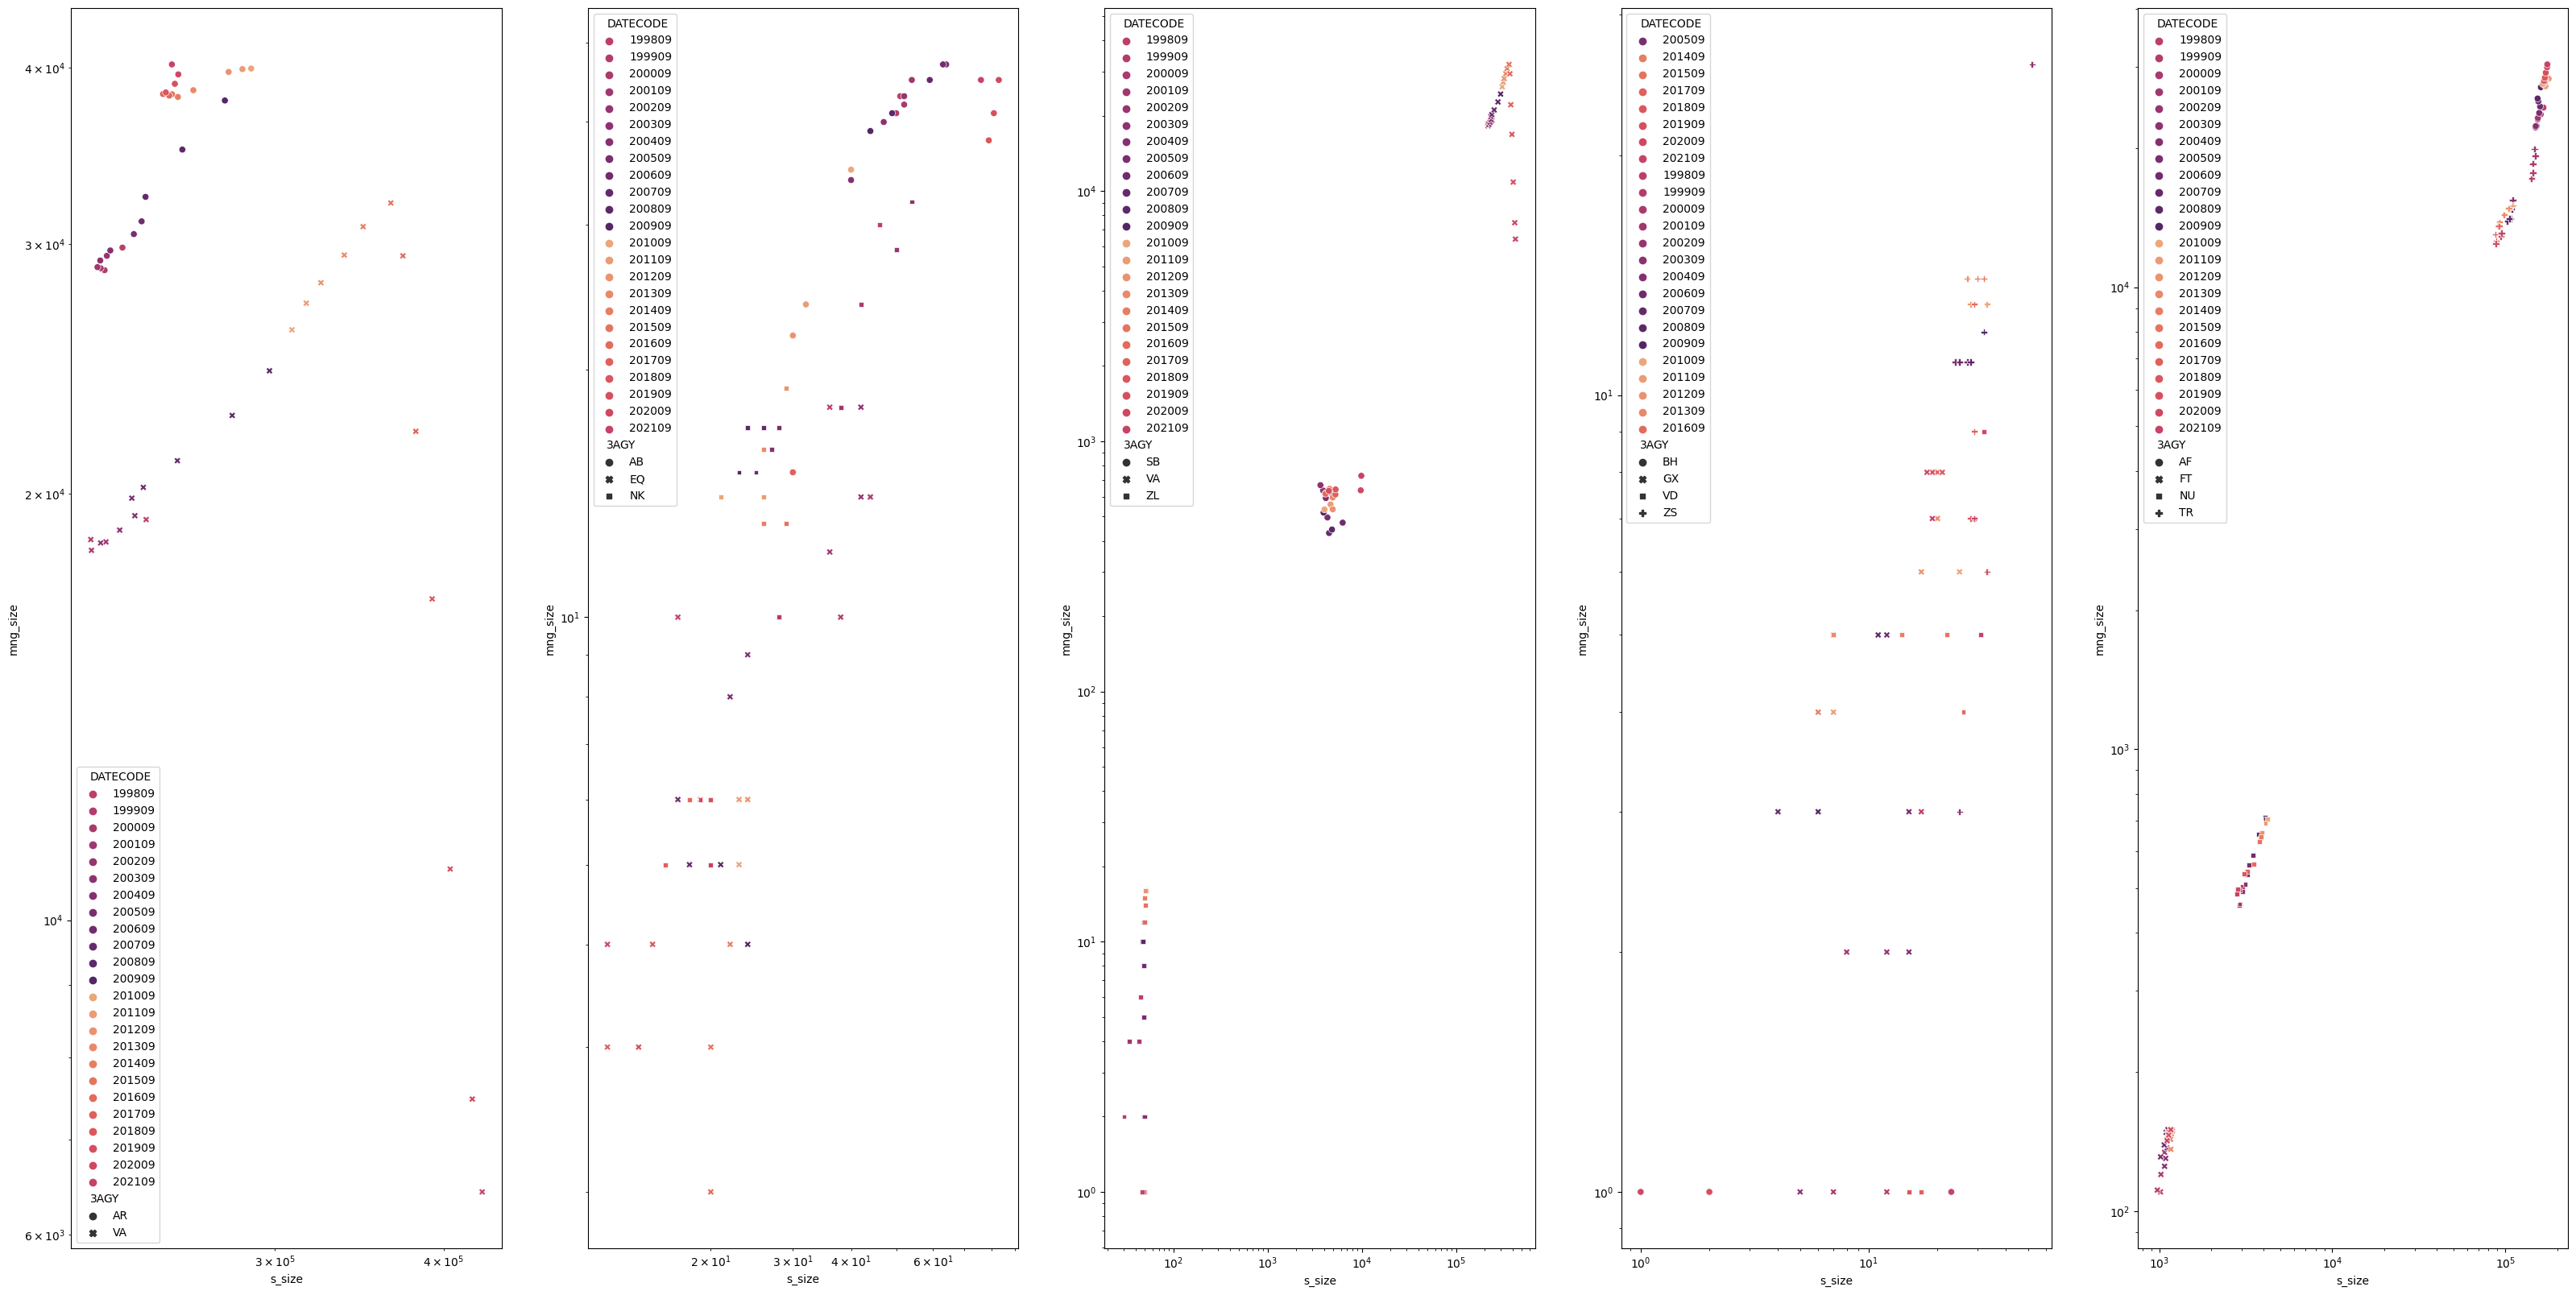

<Figure size 640x480 with 0 Axes>

In [21]:
scale_plot(df,'by_ts')

In [43]:
agy = df['3AGY'].unique()
agy

array(['AA', 'AB', 'AC', 'AD', 'AF', 'AG', 'AH', 'AI', 'AM', 'AN', 'AP',
       'AR', 'AU', 'AW', 'BD', 'BF', 'BG', 'BH', 'BK', 'BO', 'BT', 'BW',
       'BZ', 'CC', 'CE', 'CF', 'CG', 'CM', 'CT', 'CU', 'CX', 'DA', 'DB',
       'DD', 'DF', 'DG', 'DJ', 'DL', 'DN', 'DO', 'DQ', 'EB', 'EC', 'ED',
       'EE', 'EK', 'EM', 'EO', 'EP', 'EQ', 'EV', 'EW', 'EX', 'FC', 'FD',
       'FI', 'FJ', 'FK', 'FL', 'FM', 'FQ', 'FR', 'FT', 'FW', 'FY', 'GB',
       'GC', 'GE', 'GG', 'GJ', 'GM', 'GN', 'GO', 'GQ', 'GS', 'GU', 'GW',
       'GX', 'GY', 'GZ', 'HB', 'HD', 'HE', 'HF', 'HP', 'HS', 'HT', 'HU',
       'HW', 'IB', 'IF', 'IG', 'IN', 'IP', 'IW', 'JL', 'KS', 'KY', 'LF',
       'LP', 'LT', 'MA', 'MC', 'MI', 'NF', 'NK', 'NL', 'NM', 'NN', 'NP',
       'NQ', 'NS', 'NU', 'NV', 'OM', 'OS', 'PC', 'PU', 'QQ', 'RE', 'RF',
       'RH', 'RO', 'RR', 'RS', 'RZ', 'SB', 'SE', 'SK', 'SM', 'SS', 'ST',
       'SZ', 'TB', 'TC', 'TD', 'TN', 'TR', 'TS', 'TW', 'UJ', 'UT', 'VA',
       'VB', 'VD', 'WK', 'WX', 'YA', 'YB', 'YD', 'Y

In [7]:
df = pd.read_pickle("checking_in.pkl")
df['DATECODE'] = df['DATECODE'].astype('object')
dates = df['DATECODE'].unique()
colors = sns.color_palette("flare", as_cmap=True,n_colors=len(dates))
palette={date: [*color, 1.0] for date, color in zip(dates, colors)} #color and transparent
space_resol_angle = dict(
    # top1=['VA', 'AR'],
    # high_freq = ['VD'],
    # low_freq = ['AF'],
    top1=['VA', 'AR'],
    # top5=['VA', 'AR', 'NV','AF','HS'],
    # high_reg_frac = ['AB', 'NK', 'EQ'],
    # low_reg_frac = ['ZL', 'VA', 'SB'],
    # high_freq = ['VD', 'GX', 'BH', 'ZS'],
    # low_freq = ['AF', 'TR', 'NU', 'FT'], 
    # theor_responsive = ['NN', 'NF', 'JL', 'HB']
    )
for i, agg in enumerate(space_resol_angle.values()):
    df_by_ts = df[df['3AGY'].isin(agg)]
    df_by_ts['mng_size'] = df_by_ts['s_size'] * df_by_ts['reg_frac'] 
    fig, ax = plt.subplots(1,1, figsize = (20,10))
    ax.tick_params(axis='x', rotation=45)
    ax.set(xscale="log", yscale="log")
    sns.scatterplot(df_by_ts, x='s_size', y='mng_size',hue='DATECODE', style = '3AGY', ax =ax, palette=palette)

TypeError: 'ListedColormap' object is not iterable

<AxesSubplot: xlabel='s_size', ylabel='mng_size'>

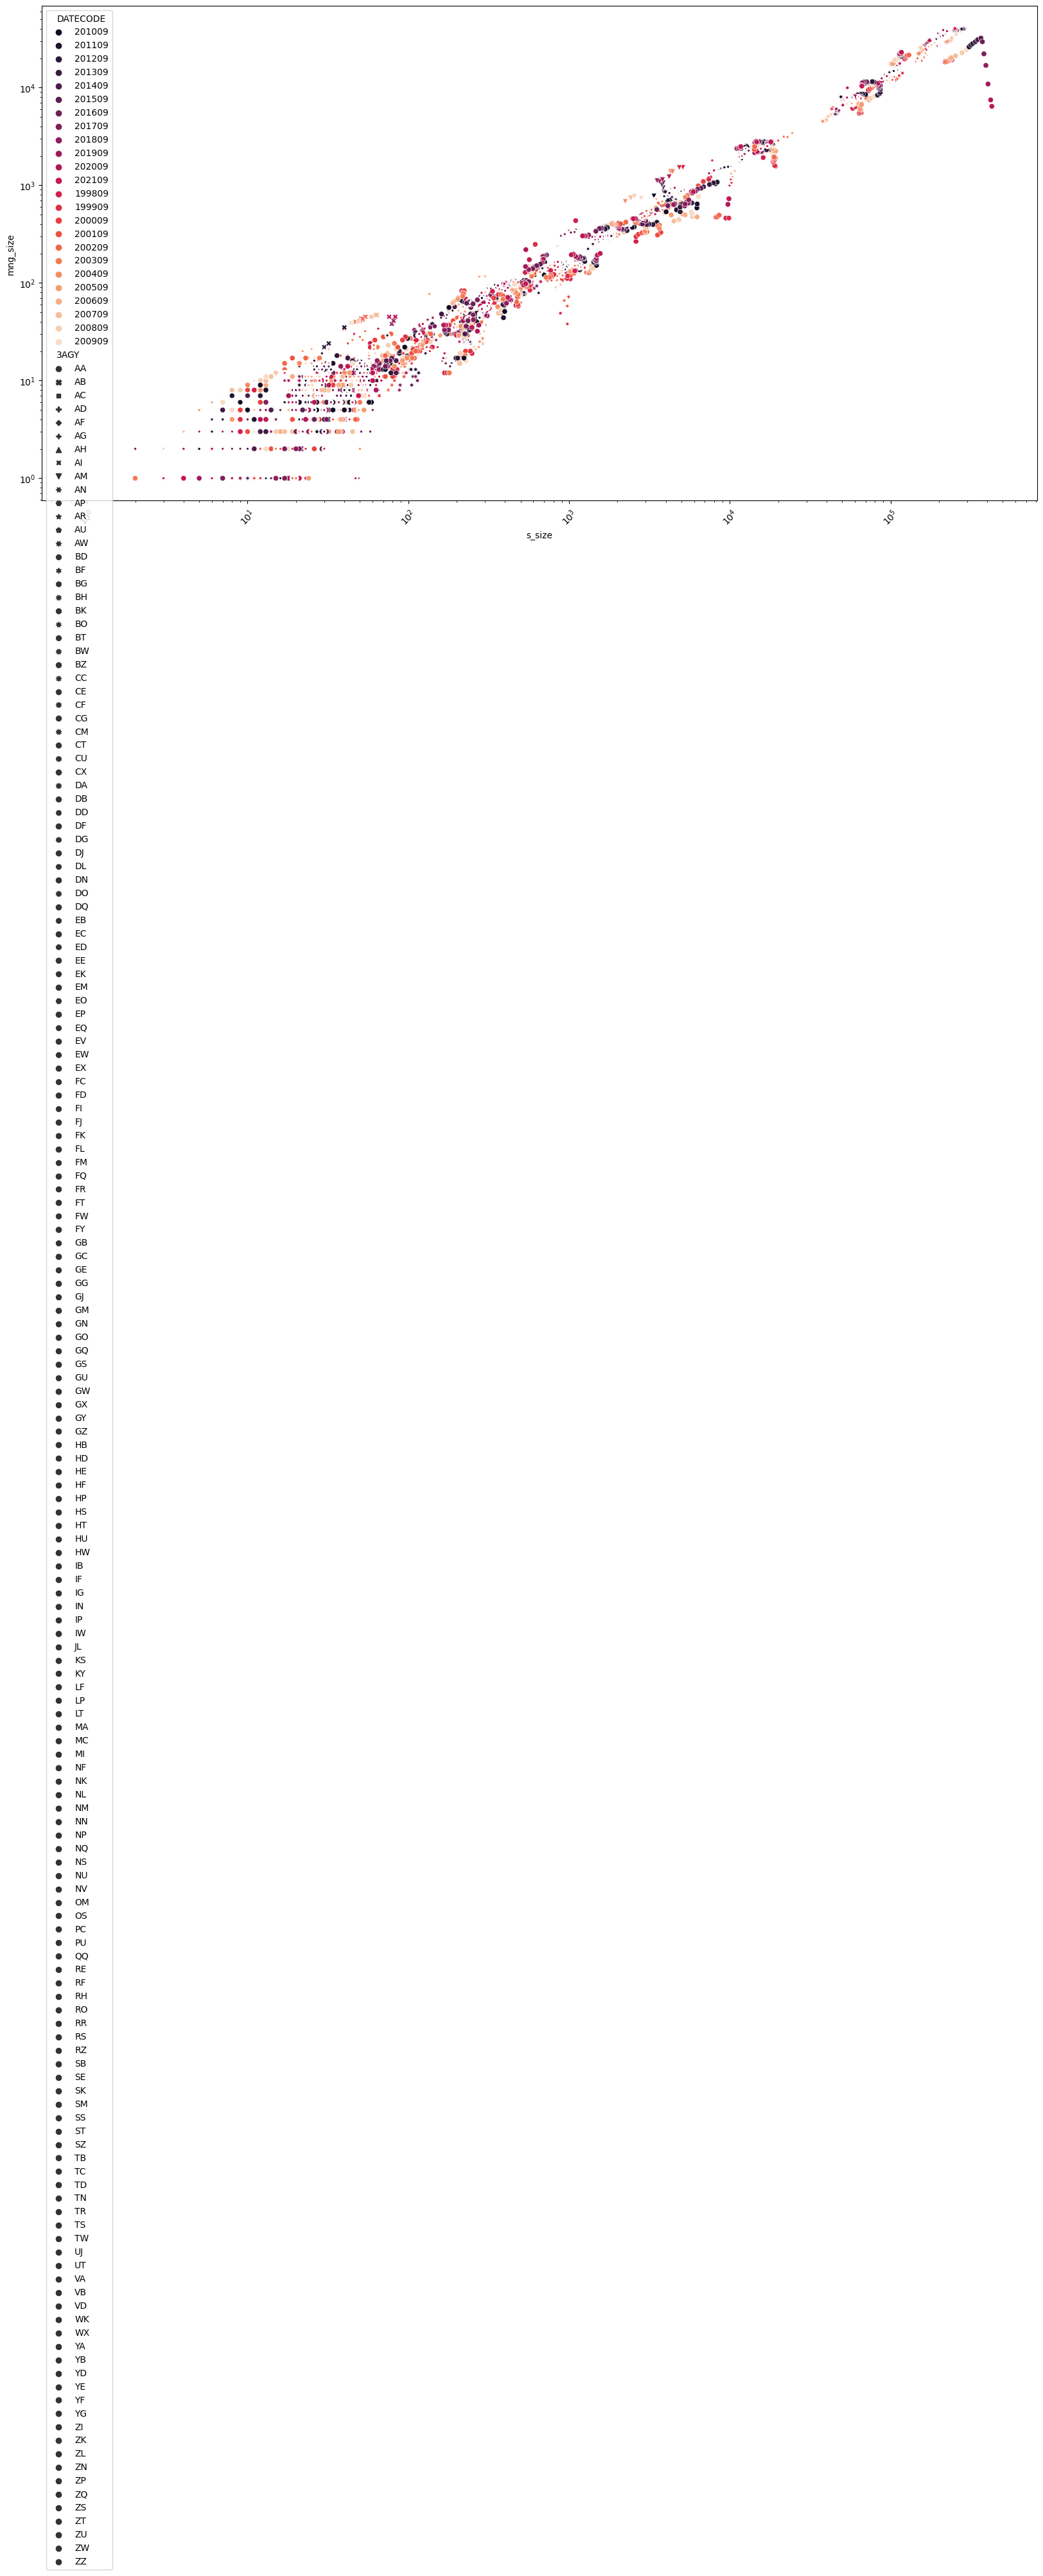

In [134]:
colors = sns.color_palette("rocket",n_colors=len(dates))
palette={date: [*color, 1.0] for date, color in zip(dates, colors)} #color and transparent
df = pd.read_pickle("checking_in.pkl")
#df['DATECODE']= df['DATECODE'].astype('int')
df['mng_size'] = df['s_size'] * df['reg_frac'] 
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.tick_params(axis='x', rotation=45)
ax.set(xscale="log", yscale="log")
sns.scatterplot(df, x='s_size', y='mng_size',hue='DATECODE', style = '3AGY', ax =ax, palette=palette)

<AxesSubplot: xlabel='DATECODE', ylabel='reg_frac'>

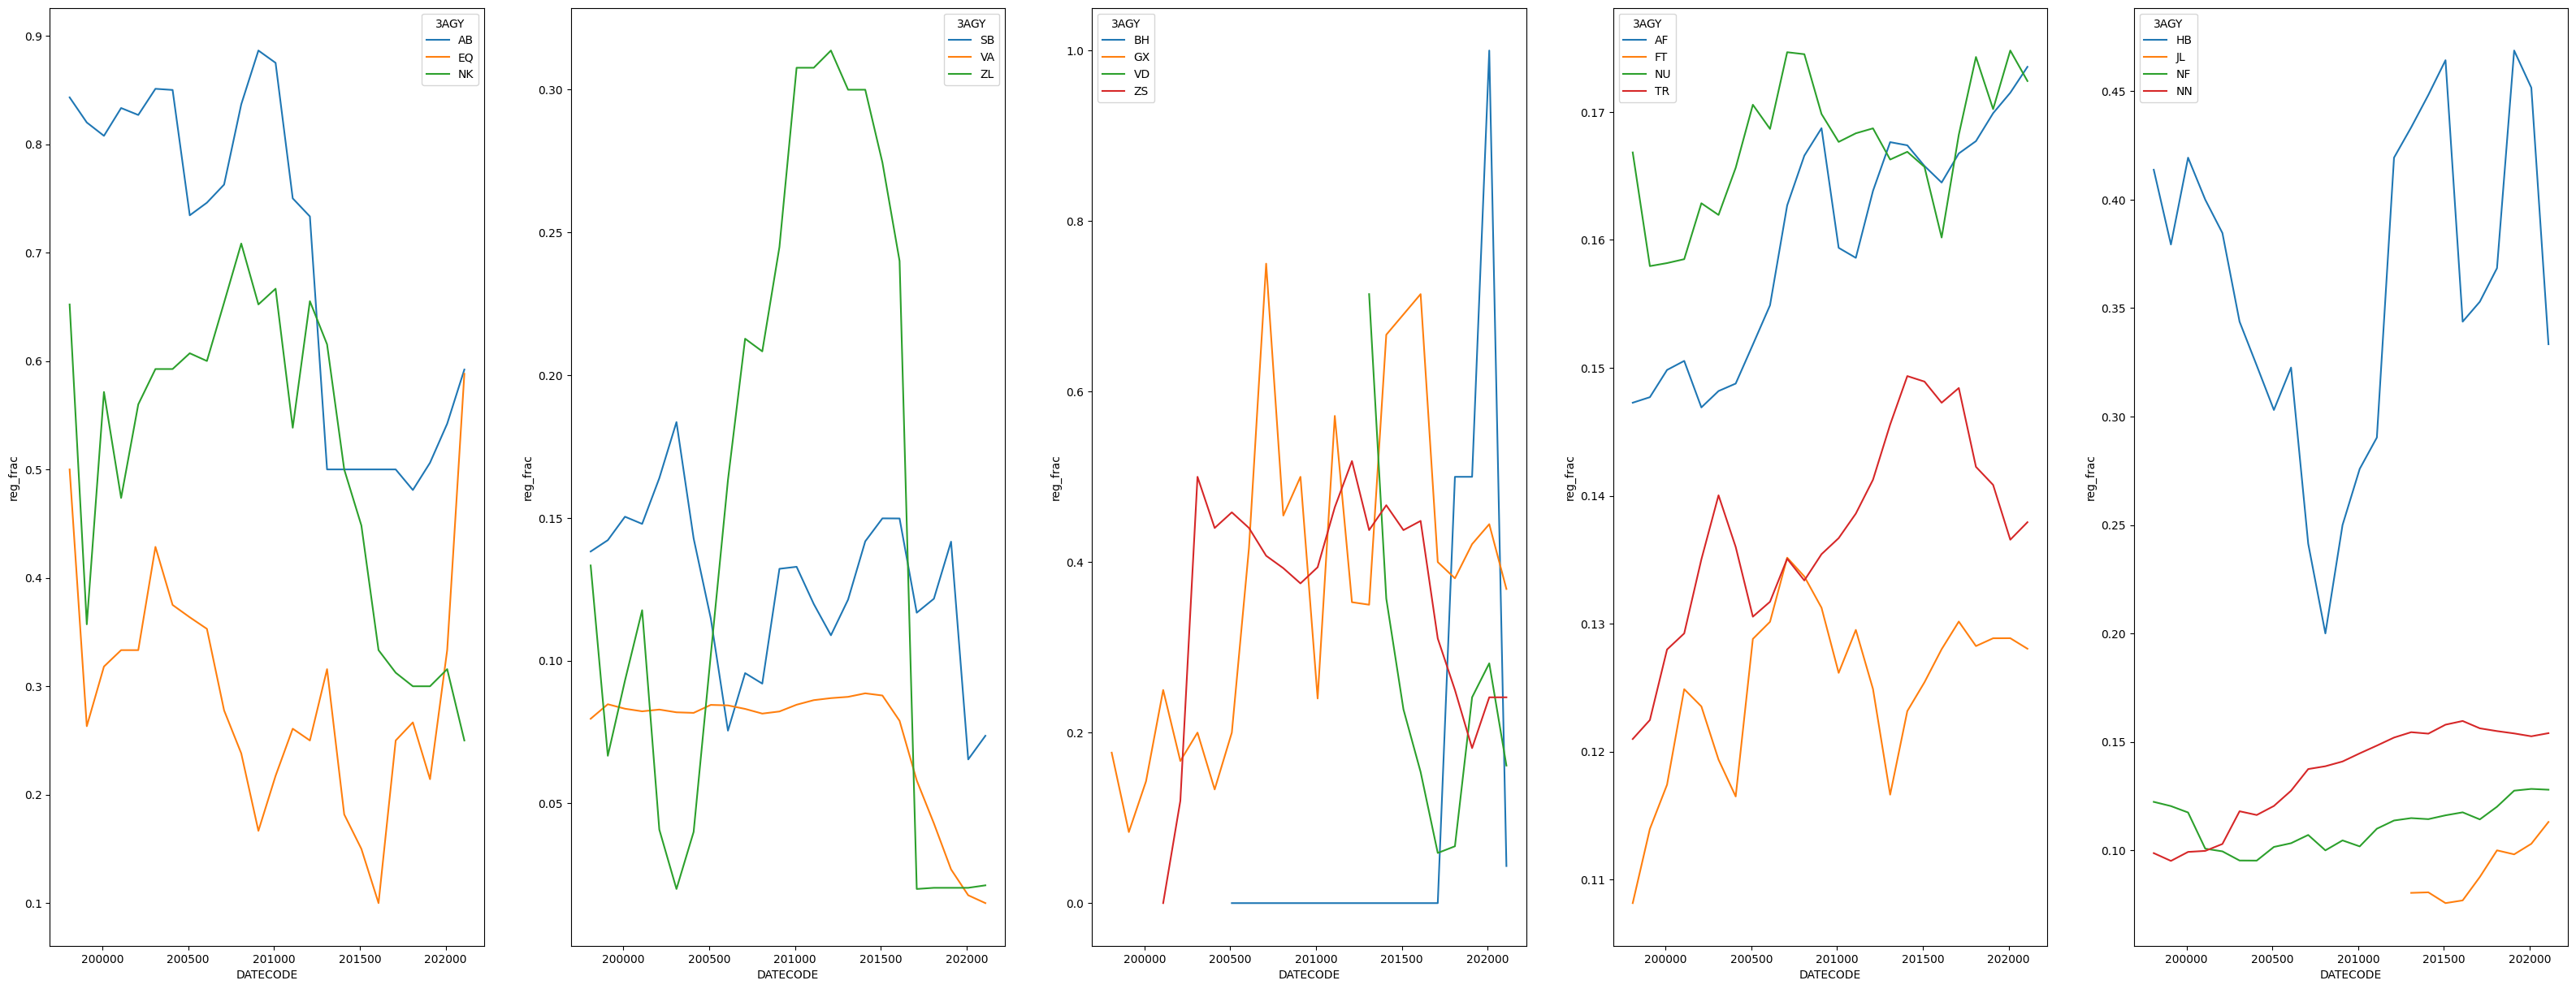

<AxesSubplot: xlabel='DATECODE', ylabel='s_size'>

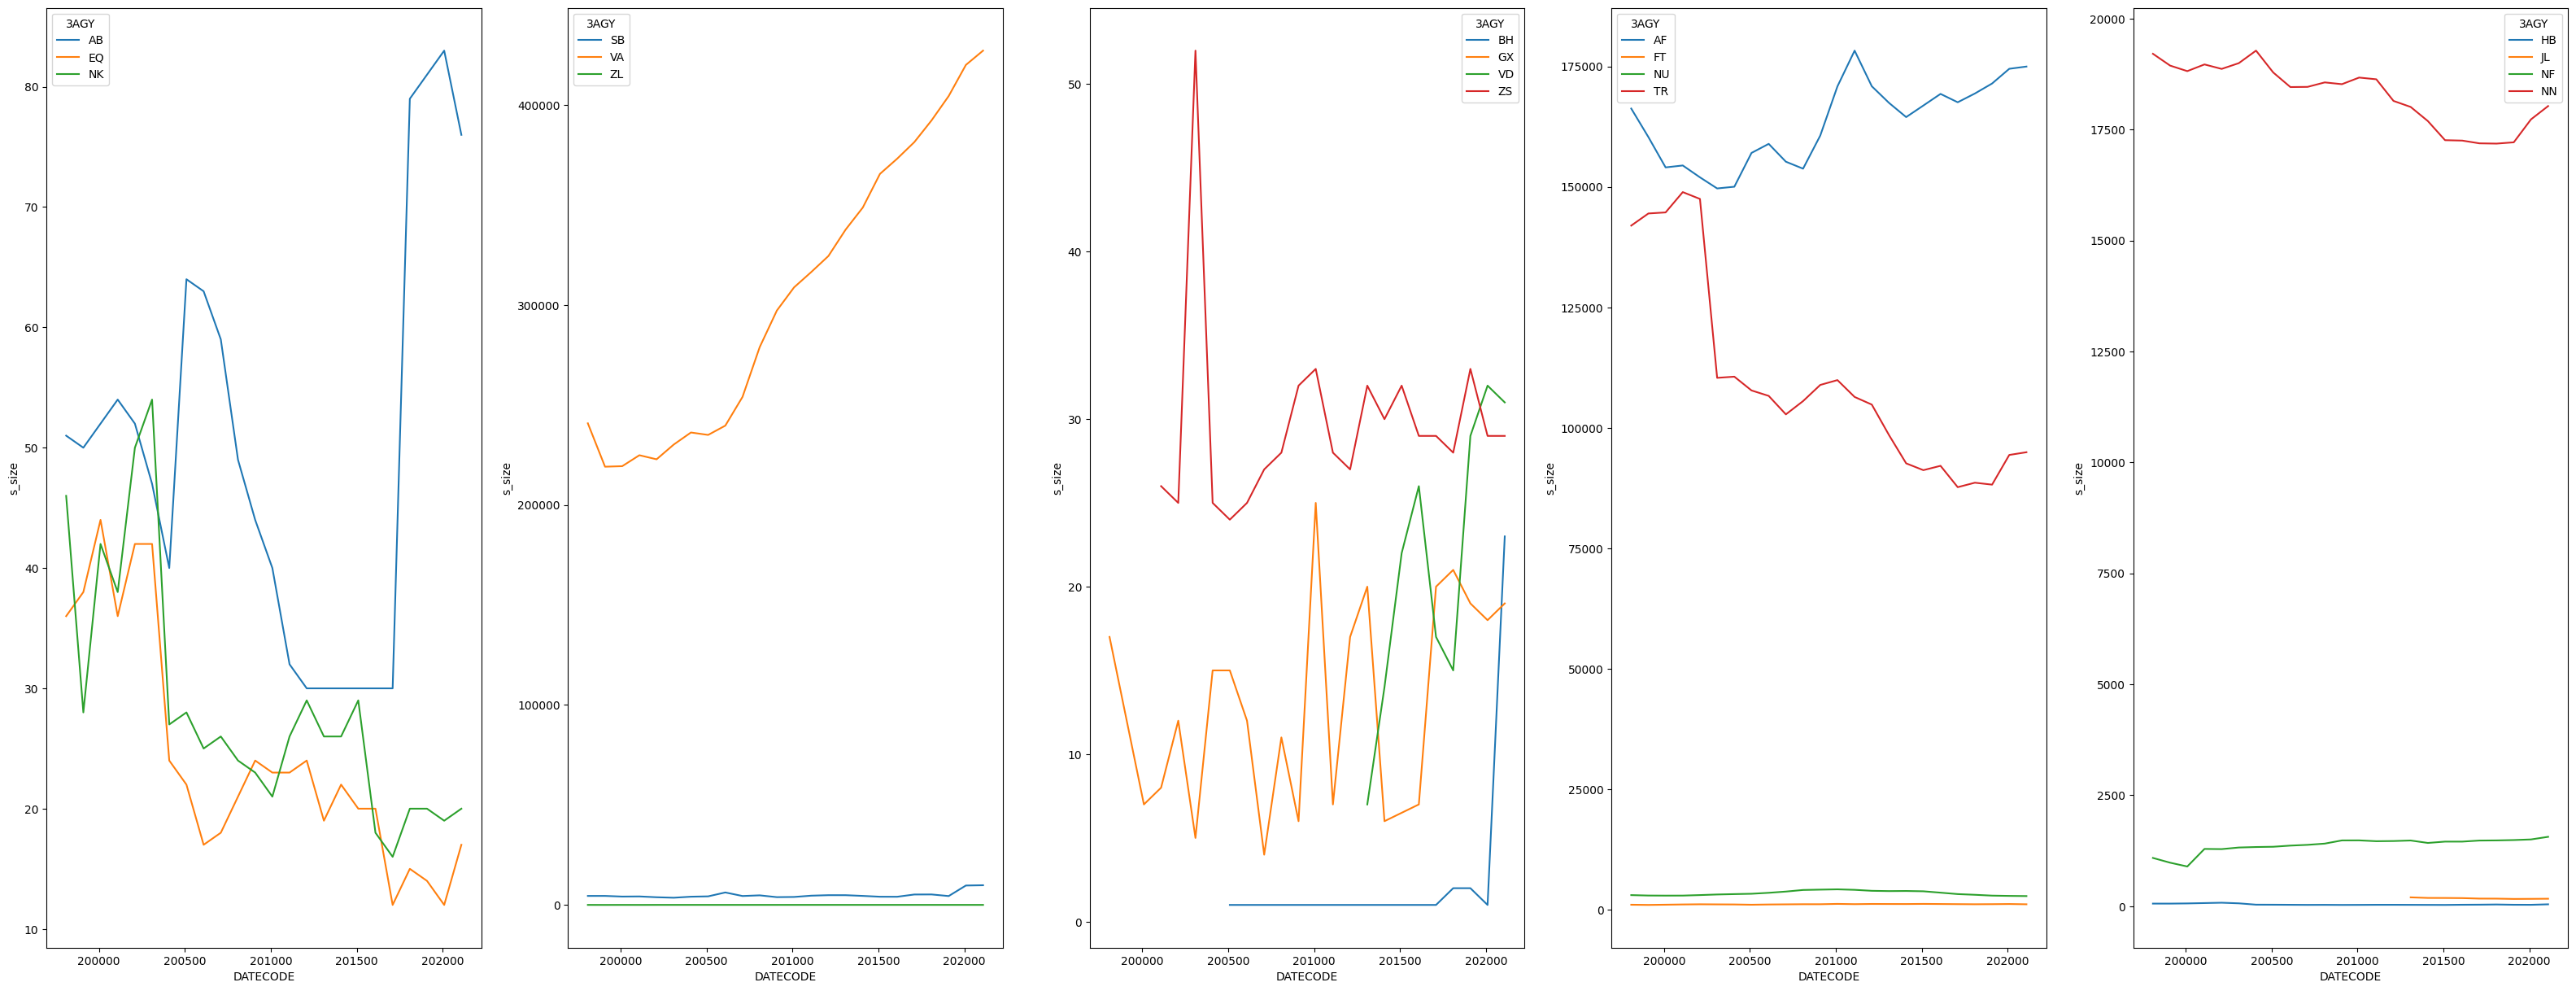

In [135]:
fig, axes = plt.subplots(1,5, figsize  = (40,15))
sns.lineplot(df[df['3AGY'].isin(high_reg_frac)], x = 'DATECODE', y = 's_size', ax = axes[0], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(low_reg_frac)], x = 'DATECODE', y = 's_size', ax = axes[1], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(high_freq)], x = 'DATECODE', y = 's_size', ax = axes[2], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(low_freq)], x = 'DATECODE', y = 's_size', ax = axes[3], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(theor_responsive)], x = 'DATECODE', y = 's_size', ax = axes[4], hue = '3AGY')

<AxesSubplot: xlabel='DATECODE', ylabel='5is_mng'>

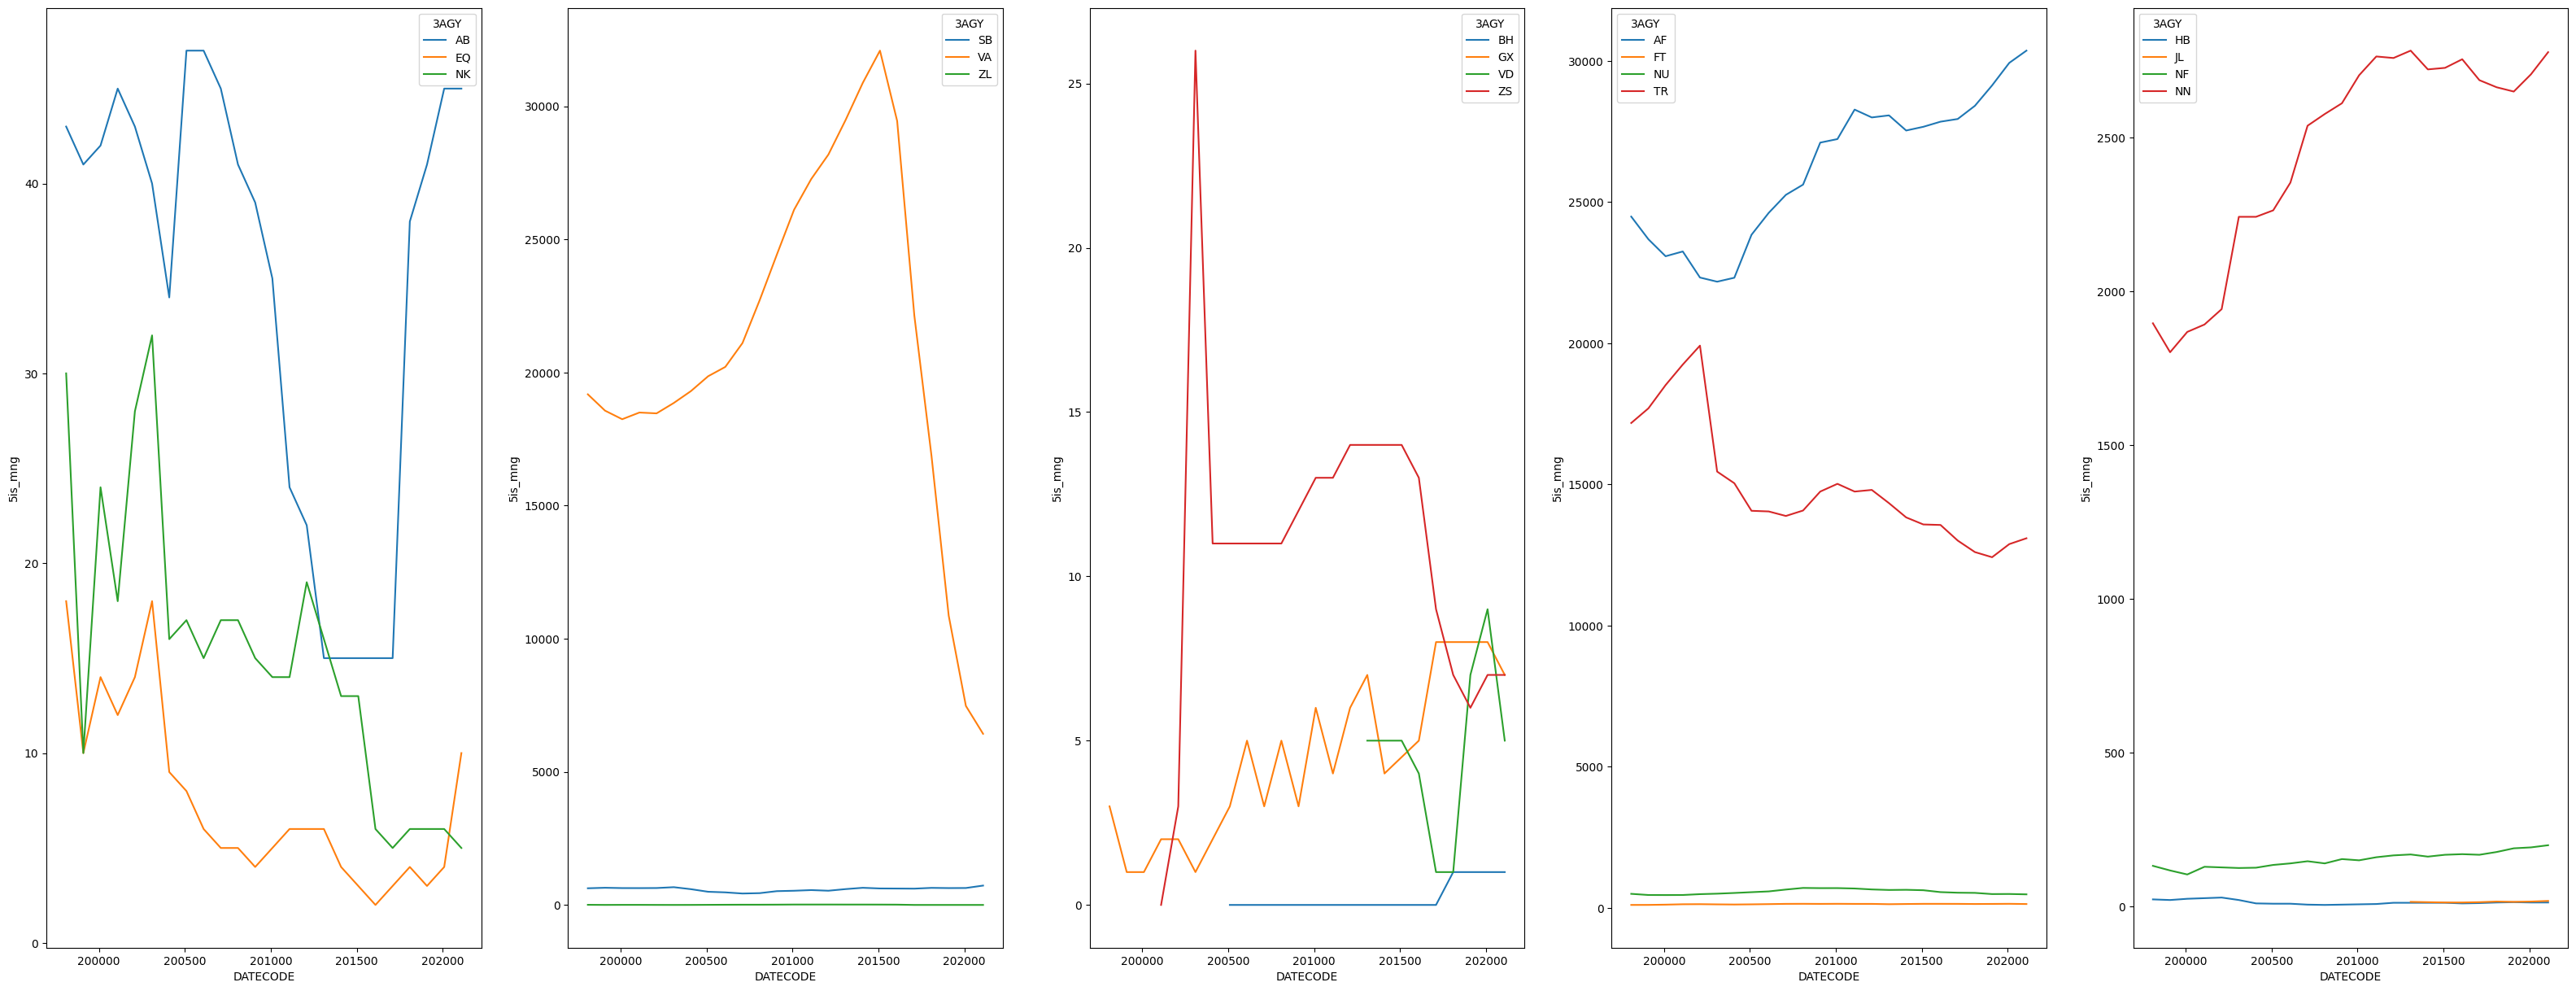

In [136]:
fig, axes = plt.subplots(1,5, figsize  = (40,15))
sns.lineplot(df[df['3AGY'].isin(high_reg_frac)], x = 'DATECODE', y = '5is_mng', ax = axes[0], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(low_reg_frac)], x = 'DATECODE', y = '5is_mng', ax = axes[1], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(high_freq)], x = 'DATECODE', y = '5is_mng', ax = axes[2], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(low_freq)], x = 'DATECODE', y = '5is_mng', ax = axes[3], hue = '3AGY')
sns.lineplot(df[df['3AGY'].isin(theor_responsive)], x = 'DATECODE', y = '5is_mng', ax = axes[4], hue = '3AGY')

In [177]:
2020: a (4: 1, 3), bank-b (5: 2,3) 9

2021: a (3: 1,2), b (6:2,4),c (3: 1,2) 12

concat(20,21): index 21
(time, agy, agysub, is_mng, index) 
(20, a, 1, 1) 
(21, a, 0, 2)
(21, a, 0, 3) 
(21, a, 0, 4)
(21, b, 1, 5) 
4d array
each state has the same department (elements will be shared) - army and bank would have a,b,c element

time = 2020
agency army bank/sub_agency (a,b)
a [[1, 0],
b  [0, 2],
c  [0, 0]],
time = 2021
[[1, 0],
 [0, 2],
 [0, 1]] 
# groupby over agency and subagency
c = xr.concat([a,b], data_vars = '3AGY', dim = 'index') #four and two 

ValueError: unexpected value for data_vars: 3AGY

In [182]:
agency98_21

<xarray.Dataset>
Dimensions:     (index: 47546547)
Coordinates:
  * index       (index) int64 0 1 2 3 4 ... 2191007 2191008 2191009 2191010
Data variables:
    DATECODE    (index) int64 199809 199809 199809 ... 202109 202109 202109
    SALARY      (index) object '$42,709' '$31,045' ... 41000.0 170800.0
    EMPLOYMENT  (index) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    2AGYTYP     (index) int64 4 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    3AGY        (index) object 'AB' 'AB' 'AB' 'AB' 'AB' ... 'ZS' 'ZS' 'ZS' 'ZU'
    4AGYSUB     (index) object 'AB00' 'AB00' 'AB00' ... 'ZS00' 'ZS00' 'ZU00'
    5is_mng     (index) bool True True False True ... False False False False

In [110]:
agency_bytime = agency98_21.groupby('DATECODE')
# Q1.from decreasing agytyp mean, (categorized into four as 1: 'Cabinet Level Agencies':  2: 'Large Independent Agencies (1000 or more employees)':  (categorized to 1-4 dep on absolute size) mean
# Q2.manager ratio peaked during 20s and is falling
mng_ratio = agency_bytime.mean() # 5is_mng count is the number of employee of each agency at each year - how to plot?
org_size = agency_bytime.count() # Employement count is the number of employee of each agency at each year - how to plot?

<xarray.Dataset>
Dimensions:     (DATECODE: 24)
Coordinates:
  * DATECODE    (DATECODE) int64 199809 199909 200009 ... 201909 202009 202109
Data variables:
    EMPLOYMENT  (DATECODE) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    2AGYTYP     (DATECODE) float64 1.117 1.119 1.116 1.116 ... 1.083 1.085 1.084
    5is_mng     (DATECODE) float64 0.1225 0.125 0.1262 ... 0.1361 0.1354 0.1344
<xarray.Dataset>
Dimensions:     (DATECODE: 24)
Coordinates:
  * DATECODE    (DATECODE) int64 199809 199909 200009 ... 201909 202009 202109
Data variables:
    SALARY      (DATECODE) int64 1809765 1772258 1760526 ... 1884189 1889613
    EMPLOYMENT  (DATECODE) int64 1818143 1779814 1767443 ... 2181106 2191011
    2AGYTYP     (DATECODE) int64 1818143 1779814 1767443 ... 2181106 2191011
    3AGY        (DATECODE) int64 1818143 1779814 1767443 ... 2181106 2191011
    4AGYSUB     (DATECODE) int64 1818143 1779814 1767443 ... 2181106 2191011
    5is_mng     (DATECODE) int64 1818143 1779814 1767443 ... 21

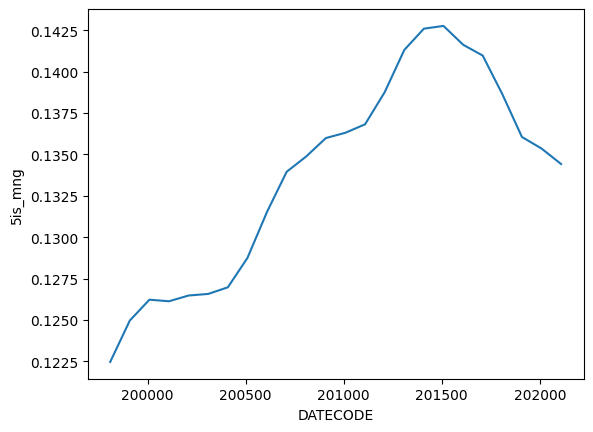

In [119]:
mng_ratio['5is_mng'].plot()

Federal agency size peak during 2010 https://en.wikipedia.org/wiki/Dodd%E2%80%93Frank_Wall_Street_Reform_and_Consumer_Protection_Act; 

- observation: nonmanager is mostly being laid off (25 (5, 20) -> 15 (4, 11))
- layoff time can be estimated
- 


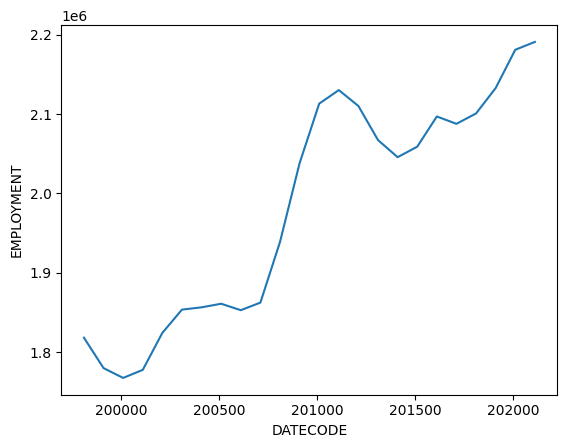

In [118]:
org_size['EMPLOYMENT'].plot()

- 3d plot that shows [5is_mng] against [time, 3agy] 
- 3d plot that shows [employment] against [time, 3agy] 

In [98]:
agencyid98_21 = agency98_21.stack(agy_time = ['DATECODE', '3AGY'])

ValueError: conflicting dimensions for multi-index product variables 'DATECODE' ('index',), '3AGY' ('index',)

In [101]:
agency98_21.where(agency98_21["DATECODE"] == 202109, drop=True)
sup = df.groupby("3AGY")['5is_mng'].sum()
tot = df.groupby("3AGY")['EMPLOYMENT'].count()
suptot = pd.concat([sup, tot], axis = 1)
suptot["ratio"]= suptot["5is_mng"]/suptot["EMPLOYMENT"]

KeyError: '3AGY'

In [95]:
da_multiindex = da.stack(my_multiindex=['time.year','time.month'])

da_mean = da.groupby("my_multiindex").mean()

da_mean.unstack()  # go back to normal index

agency98_21.groupby(['DATECODE','3AGY'])['5is_mng'].sum()
# sup = df.groupby("3AGY")['5is_mng'].sum()
# tot = df.groupby("3AGY")['EMPLOYMENT'].count()

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension. Received ['DATECODE', '3AGY'] instead.

In [ ]:
agency98_21.groupby(['DATECODE','3AGY'])['5is_mng'].sum()

array([[<AxesSubplot: title={'center': '5is_mng'}>,
        <AxesSubplot: title={'center': 'EMPLOYMENT'}>],
       [<AxesSubplot: title={'center': 'ratio'}>, <AxesSubplot: >]],
      dtype=object)

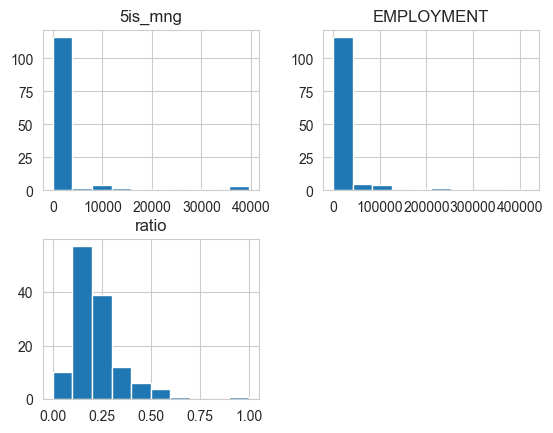

In [37]:
suptot.hist()

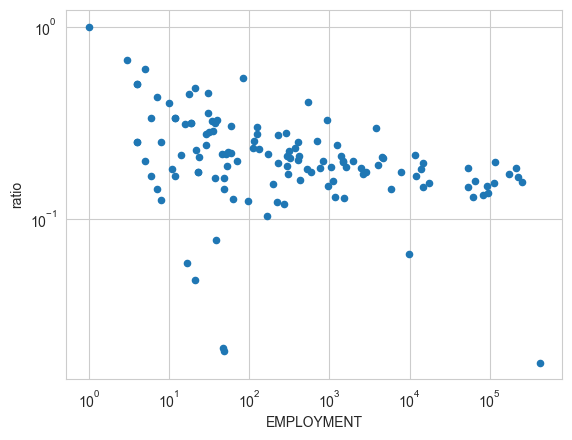

In [6]:
scale_plot(TIME)

## DYNAMIC ANALYSIS (1809 vs 2109)

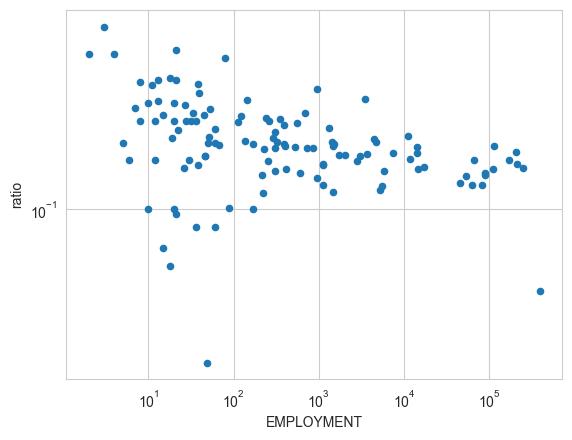

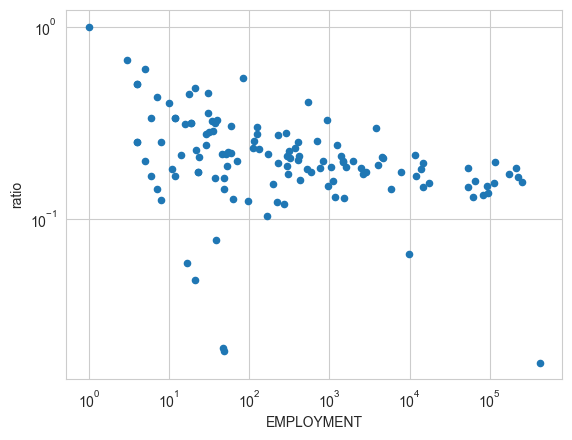

In [5]:
TIME_YEAR = ["18", "21"]
TIME_MONTH = "09"
df_dict = dict() # upgrade to xarray with time coordinate
for year in TIME_YEAR:
     TIME = year + TIME_MONTH
     #df_dict[TIME] = hierarchize_org(TIME, features = ['SALARY', 'EMPLOYMENT'], layers = 5) # create pkl
     scale_plot(TIME)

## DIVING INTO HIERARCHY

In [25]:
for i in range(2, df.shape[1]):
     a = pd.unique(df.iloc[:, i])
     print(df.columns[i], len(a),a)

2AGYTYP 4 [4 1 3 2]
3AGY 130 ['AA' 'AB' 'AF' 'AG' 'AH' 'AM' 'AN' 'AP' 'AR' 'AU' 'AW' 'BD' 'BF' 'BG'
 'BH' 'BK' 'BO' 'BT' 'BW' 'CC' 'CE' 'CF' 'CM' 'CT' 'CU' 'CX' 'DB' 'DD'
 'DG' 'DJ' 'DL' 'DN' 'DQ' 'EB' 'EC' 'ED' 'EE' 'EO' 'EP' 'EQ' 'EW' 'FC'
 'FD' 'FI' 'FJ' 'FK' 'FL' 'FM' 'FQ' 'FR' 'FT' 'FW' 'GB' 'GC' 'GE' 'GG'
 'GJ' 'GQ' 'GS' 'GU' 'GW' 'GX' 'GY' 'GZ' 'HB' 'HD' 'HE' 'HF' 'HP' 'HS'
 'HT' 'HU' 'HW' 'IB' 'IF' 'IG' 'IN' 'IP' 'JL' 'KS' 'KY' 'LF' 'LP' 'MA'
 'MC' 'MI' 'NF' 'NK' 'NL' 'NM' 'NN' 'NP' 'NQ' 'NS' 'NU' 'NV' 'OM' 'OS'
 'PU' 'QQ' 'RE' 'RF' 'RH' 'RO' 'RR' 'RS' 'SB' 'SE' 'SK' 'SM' 'SS' 'ST'
 'SZ' 'TB' 'TC' 'TD' 'TN' 'TR' 'TS' 'TW' 'UJ' 'UT' 'VA' 'VD' 'WK' 'WX'
 'ZL' 'ZP' 'ZS' 'ZU']
4AGYSUB 533 ['AA00' 'AB00' 'AF02' 'AF03' 'AF06' 'AF07' 'AF09' 'AF0B' 'AF0D' 'AF0J'
 'AF0M' 'AF0R' 'AF0U' 'AF0V' 'AF12' 'AF13' 'AF16' 'AF17' 'AF1B' 'AF1C'
 'AF1L' 'AF1M' 'AF1Q' 'AF1S' 'AF1Y' 'AF20' 'AF2A' 'AF2E' 'AF2F' 'AF2H'
 'AF2I' 'AF2K' 'AF2L' 'AF2M' 'AF2R' 'AF2S' 'AF2T' 'AF2Z' 'AF34' 'AF38'
 'AF3C' 'AF3D'

In [105]:
# set(df_af.AGYSUBT)

{'AF02-AIR FORCE INSPECTION AGENCY (FO)',
 'AF03-AIR FORCE OPERATIONAL TEST AND EVALUATION CENTER',
 'AF06-AIR FORCE AUDIT AGENCY',
 'AF07-AIR FORCE OFFICE OF SPECIAL INVESTIGATIONS',
 'AF09-AIR FORCE PERSONNEL CENTER',
 'AF0B-U.S. AIR FORCE ACADEMY',
 'AF0D-U.S. AIR FORCES, EUROPE',
 'AF0J-AIR EDUCATION AND TRAINING COMMAND',
 'AF0M-HEADQUARTERS, AIR FORCE RESERVE COMMAND',
 'AF0R-PACIFIC AIR FORCES',
 'AF0U-25 AF',
 'AF0V-AIR FORCE SPECIAL OPERATIONS COMMAND',
 'AF12-AIR FORCE PUBLIC AFFAIRS AGENCY',
 'AF13-HQ USAF AND SUPPORT ELEMENTS',
 'AF16-AIR FORCE MORTUARY AFFAIRS OPERATIONS',
 'AF17-AF INSTALLATION AND MISSION SUPPORT',
 'AF1B-AIR FORCE MANPOWER ANALYSIS AGENCY',
 'AF1C-AIR COMBAT COMMAND',
 'AF1L-AIR MOBILITY COMMAND',
 'AF1M-AIR FORCE MATERIEL COMMAND',
 'AF1Q-HQ AF FLIGHT STANDARDS AGENCY',
 'AF1S-HEADQUARTERS, AIR FORCE SPACE COMMAND',
 'AF1Y-AIR FORCE CIVILIAN CAREER TRAINING',
 'AF20-AIR FORCE AGENCY FOR MODELING/SIMULATION',
 'AF2A-AIR FORCE COST ANALYSIS AGENCY',
 'AF

## practicing xarray

In [ ]:
ag = agency98_21_byaid.groupby('index')
ag.mean()

<xarray.Dataset>
Dimensions:     (index: 2922)
Coordinates:
  * index       (index) object MultiIndex
  * 3AGY        (index) object 'AB' 'AC' 'AD' 'AF' 'AG' ... 'ZL' 'ZP' 'ZS' 'ZU'
  * DATECODE    (index) int64 199809 199809 199809 ... 202109 202109 202109
Data variables:
    EMPLOYMENT  (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    2AGYTYP     (index) float64 4.0 4.0 3.0 1.0 1.0 3.0 ... 4.0 4.0 4.0 4.0 4.0
    5is_mng     (index) float64 0.8431 0.4211 0.1284 ... 0.3226 0.2414 0.0

In [ ]:
ag.count()

<xarray.Dataset>
Dimensions:     (index: 2922)
Coordinates:
  * index       (index) object MultiIndex
  * 3AGY        (index) object 'AB' 'AC' 'AD' 'AF' 'AG' ... 'ZL' 'ZP' 'ZS' 'ZU'
  * DATECODE    (index) int64 199809 199809 199809 ... 202109 202109 202109
Data variables:
    SALARY      (index) int64 45 6 254 165380 107636 388 70 ... 9 4 47 23 29 1
    EMPLOYMENT  (index) int64 51 19 257 166258 107709 399 71 ... 9 7 47 31 29 1
    2AGYTYP     (index) int64 51 19 257 166258 107709 399 71 ... 9 7 47 31 29 1
    4AGYSUB     (index) int64 51 19 257 166258 107709 399 71 ... 9 7 47 31 29 1
    5is_mng     (index) int64 51 19 257 166258 107709 399 71 ... 9 7 47 31 29 1

In [ ]:
agency98_21.expand_dims('DATECODE')

ValueError: DATECODE already exists as coordinate or variable name.

In [ ]:
agency98_21
# count, 3d array tidyverse lib defined data repres (obs is a row, row has all feature)
# arviz has one datastructure (if only in dataframe - tidy)
# can have multidim array with label, (automatic align)

<xarray.Dataset>
Dimensions:     (index: 47546547)
Coordinates:
  * index       (index) int64 0 1 2 3 4 ... 2191007 2191008 2191009 2191010
Data variables:
    DATECODE    (index) int64 199809 199809 199809 ... 202109 202109 202109
    SALARY      (index) object '$42,709' '$31,045' ... 41000.0 170800.0
    EMPLOYMENT  (index) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    2AGYTYP     (index) int64 4 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    3AGY        (index) object 'AB' 'AB' 'AB' 'AB' 'AB' ... 'ZS' 'ZS' 'ZS' 'ZU'
    4AGYSUB     (index) object 'AB00' 'AB00' 'AB00' ... 'ZS00' 'ZS00' 'ZU00'
    5is_mng     (index) bool True True False True ... False False False False